# Confidence intervals

The goal of system evaluation is to predict the performance our system will have when deployed. That is, we want to know the performance on some yet-unseen dataset. We do this by computing some performance metric of choice --one that is relevant to our application-- on a test dataset, assuming that this data is representative of the deployment data. Now, the metric value we obtain may be too good or too bad, compared to what we will actually see during deployment, simply because our test dataset happens to be uncharacteristically easy or hard. This is, of course, more likely to happen on small datasets than on large ones.

Confidence intervals are meant to give us an idea of how far off our estimate may be from the performance we will actually see in practice. There are many ways of estimating confidence intervals. Here we implement the bootstraping-based approach which is very general and flexible. It can be used for any performance metric and it can take into account known correlations in the dataset. For example, if the test dataset is composed of samples from different speakers, each contributing various samples, the speaker identity will introduce correlations between the samples. Ignoring these correlations when computing confidence intervals would result in intervals that are narrower than they should be. Bootstrapping can be easily modified to take these correlation-inducing factors into account.

The basic steps to compute confidence intervals based on the bootstrapping approach are as follow. Given a test dataset with $N$ samples:

1. Repeat the two steps below $B$ times.
   * Sample the dataset with replacement to get $N$ samples. The new dataset will be of the same size as the original, but will have some missing and some repeated samples. 
   * Compute the performance metric of interest on the new set.
2. Pool the $B$ metric values obtained above. We now have an empirical distribution of metric values.
3. For a $\alpha$% confidence interval, compute the $\alpha/2$ and the $100-\alpha/2$ percentiles.

The resulting confidence interval will reflect the variability in the metric value due to the variability in the test data. Note, though, that given that the bootstrap sets are sampled from the test set itself and not form the original distribution, they will all have the same biases that are present in the original test dataset. For example, if your test dataset has mostly males, then the resulting confidence interval will still not adequately reflect the performance on other genders. 

The algorithm above assumes that the samples in the test set are iid. If this is not the case, for example because samples come from human subjects that contributed several samples each, then this assumption does not hold. Luckily, it is easy to modify the bootstrapping algorithm to address this case. Basically, instead of sampling individual samples, we sample ``conditions'' (in the example, the condition would be the subject identifier). The new dataset is then created by including all the samples from each selected condition. If a condition was sampled $n$ times, we include each of its samples $n$ times.

In this notebook we show the way to obtain confidence intervals for cross-entropy and calibration loss. The approach, though, can be used for any performance metric.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from expected_cost import ec, utils
from expected_cost.data import create_scores_for_expts
from expected_cost.calibration import calibration_with_crossval, calibration_train_on_test
from expected_cost.psrcal_wrappers import Brier, LogLoss, CalLoss, ECEbin
from psrcal.calibration import HistogramBinningCal
from psrcal.losses import plot_reliability_diagram

# Method to obtain the 95% confidence interval    
def get_conf_int(vals, alpha=5):
    print("Confidence interval: %5.2f  %5.2f"%(np.percentile(vals, alpha/2), np.percentile(vals, 100-alpha/2)))
 

In [2]:
# Create simulated scores 
P0 = 0.8
N = 400
K = 2
score_dict, targets = create_scores_for_expts(K, P0=P0, feat_std=0.20, N=N)

# You can try different scores from the scores_dict:

# Well-calibrated ones:
scores = score_dict['cal']['Datap'] 

# Miscalibrated due to scaling in the logit domain
# scores = score_dict['mc2']['Datap'] 

# Miscalibrated due to mismatched priors between training and test data
# scores = score_dict['cal']['Mismp'] 

# Miscalibrated for both reasons
#scores = score_dict['mc2']['Mismp'] 

# Here we assume we do not have correlation-inducing conditions. In case there were, the conditions
# variable would have to be set to contain the condition indices for every sample in the scores array.
conditions = None

metric = LogLoss # LogLoss, Brier, or any other metric of your choice

numbootstraps = 100
raw_mvals, eces = [], [] # Metric values (the metric defined above, and ECE) for raw scores
cal_axv_mvals, cal_att_mvals, cal_htt_mvals = [], [], [] # Metric values for calibrated scores
cal_axv_cvals, cal_att_cvals, cal_htt_cvals = [], [], [] # Calibration loss values for those calibrated scores

# Now, sample the test set a number of times. In each case, we need to reestimate the calibration
# transforms used to obtain calibration loss. 

for nb in np.arange(numbootstraps):

    # Scores, targets and conditions for the bootstrap set. The cond_bt variable contains the
    # condition indices of the selected samples which coincide with the sample indices if the input
    # conditions are set to None.
    scores_bt, targets_bt, cond_bt = utils.create_bootstrap_set(scores, targets, conditions=None)

    # Get the metric defined above on the raw scores
    raw_mvals.append(metric(scores_bt, targets_bt))
    
    # Now compute calibration loss using different calibration approaches, just for fun.

    # First, use affine calibration with cross-validation, using cond_bt to determine the folds.
    # This is important even if conditions=None because otherwise the same exact sample may appear
    # across more than one fold which would defeat the purpose of doing xval.
    scores_bt_cal_axv = calibration_with_crossval(scores_bt, targets_bt, condition_ids=cond_bt)
    
    # Also do train-on-test for comparison.
    scores_bt_cal_att = calibration_train_on_test(scores_bt, targets_bt)

    # And, finally, try using histogram binning. You can check that increasing M results in more and
    # more overfitting of the calibration transform which in turn results in an overestimation of
    # the calibration loss.
    scores_bt_cal_htt = calibration_train_on_test(scores_bt, targets_bt, 
                                                  calmethod=HistogramBinningCal, calparams={'M': 15})

    # Now that the calibrated scores are ready, compute the metric on those scores
    cal_axv_mvals.append(metric(scores_bt_cal_axv, targets_bt))
    cal_att_mvals.append(metric(scores_bt_cal_att, targets_bt))
    cal_htt_mvals.append(metric(scores_bt_cal_htt, targets_bt))

    # And, finally, compute the calibration loss    
    cal_axv_cvals.append(CalLoss(metric, scores_bt, scores_bt_cal_axv, targets_bt))
    cal_att_cvals.append(CalLoss(metric, scores_bt, scores_bt_cal_att, targets_bt))
    cal_htt_cvals.append(CalLoss(metric, scores_bt, scores_bt_cal_htt, targets_bt))

    # Get the ECE on the raw scores. Note that even though this is done directly with the raw
    # scores, unlike the calibration loss which takes calibrated scores as input, the ECEbin method
    # is effectively doing train-on-test histogram calibration inside it. In fact, one could
    # implement calibration loss to do the calibration inside the method, but we chose to leave that
    # process explicit outside the method to make it more transparent and give the user freedom in
    # choosing how to do the calibration.
    eces.append(ECEbin(scores_bt, targets_bt))




Confidence interval: -5.93   1.44


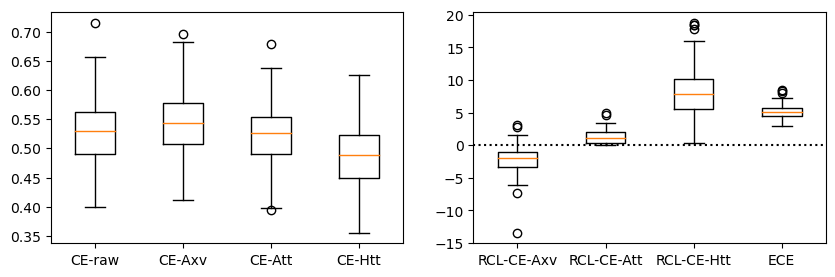

In [4]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
axs[0].boxplot([raw_mvals, cal_axv_mvals, cal_att_mvals, cal_htt_mvals], labels=("CE-raw", "CE-Axv", "CE-Att", "CE-Htt"))
axs[1].boxplot([cal_axv_cvals, cal_att_cvals, cal_htt_cvals, eces], labels=( "RCL-CE-Axv", "RCL-CE-Att", "RCL-CE-Htt", "ECE"))
axs[1].plot(axs[1].get_xlim(), [0,0], 'k:')

# Example on how to get the confidence interval using percentiles
get_conf_int(cal_axv_cvals)


Some observations from the plots above when using the calibrated scores as input for which the true calibration loss is known to be 0.

* The affine calibration with cross-validation (Axv) estimates a negative calibration loss (while the top whisker is positive, the rest of the values are negative). This is, as we explained before, because the calibration models slightly overfit the training data for each fold resulting in a degraded performance on the test set when the original scores are perfectly calibrated and there is nothing to fix.

* The affine calibration trained on the test data, on the other hand, estimates a very small positive calibration loss (in this case the whole box is above 0). This happens because the calibration model overfits and, unlike in cross-validation, the model is tested on the same data it was trained on.

* This problem is more salient when the calibration transform is given by histogram binning. 

* Finally, ECE shows the same trend, diagnosing a non-existing calibration problem, which is expected since ECE is based on the same histogram calibration transformation as RCL-CE-Htt.